In [1]:
import torch
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import wandb
import torch.nn.functional as F
import timm
from torch import nn
from sklearn.metrics import roc_curve
import math
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
drive.mount('/content/drive')
image_folder = '/content/drive/MyDrive/Курсовая/images/'
masks_folder = '/content/drive/MyDrive/Курсовая/masks_full/'
metadata_path = '/content/drive/MyDrive/Курсовая/HAM10000_metadata.tab'
ISIC2017_malignant  = '/content/drive/MyDrive/Курсовая/ISIC_2017_only_malignant/'
masks_ISIC2017_malignant = '/content/drive/MyDrive/Курсовая/ISIC_2017_only_malignant_masks/'
ISIC2017_malignant_5703 = '/content/drive/MyDrive/Курсовая/ISIC_malignant_5703/'
masks_ISIC2017_malignant_5703 = '/content/drive/MyDrive/Курсовая/ISIC_malignant_5703_masksbymodel/'
seg_model_path = '/content/drive/MyDrive/Курсовая/best_model_deeplabv3_26.04.25.pth'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(metadata_path, sep='\t', header=None)
df.columns = ['lesion_id', 'image_id', 'diagnosis', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, x + '.jpg'))
df['mask_path'] = df['image_id'].apply(lambda x: os.path.join(masks_folder, x + '.png'))
benign_diagnoses = ['bkl', 'nv', 'df', 'vasc']  # доброкачественные будут 0, злокачественные 1
df['label'] = df['diagnosis'].apply(lambda x: 0 if x in benign_diagnoses else 1)
df.drop(columns=['diagnosis'], inplace=True)
df.head()

,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0


In [4]:
benign_count = df[df['label'] == 0].shape[0]
malignant_count = df[df['label'] == 1].shape[0]
print(f'Доброкачественных: {benign_count}')
print(f'Злокачественных: {malignant_count}')
print(f'Недостаток злокачественных данных: {benign_count - malignant_count}')

Доброкачественных: 8061
Злокачественных: 1954
Недостаток злокачественных данных: 6107


In [5]:
# добавляем данные о malignant и их масках из ISIC2017

image_ids = [os.path.splitext(f)[0] for f in os.listdir(ISIC2017_malignant) if f.lower().endswith('.jpg')]
df_new = pd.DataFrame({'image_id': image_ids,
                       'image_path' : [os.path.join(ISIC2017_malignant, img + '.jpg') for img in image_ids],
                       'mask_path' : [os.path.join(masks_ISIC2017_malignant, img + '.png') for img in image_ids],
                       'label' : 1})

for col in ['lesion_id', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']:
    df_new[col] = None
cols = df.columns.tolist()
df_new = df_new[cols]
df = pd.concat([df, df_new], ignore_index=True)
df.tail()

<ipython-input-5-fc4f626e0cc0>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new], ignore_index=True)


,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
10414,None,ISIC_0015190,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10415,None,ISIC_0015082,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10416,None,ISIC_0015200,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10417,None,ISIC_0015204,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10418,None,ISIC_0015110,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1


In [6]:
benign_count = df[df['label'] == 0].shape[0]
malignant_count = df[df['label'] == 1].shape[0]
print(f'Доброкачественных: {benign_count}')
print(f'Злокачественных: {malignant_count}')
print(f'Недостаток злокачественных данных: {benign_count - malignant_count}')

Доброкачественных: 8061
Злокачественных: 2358
Недостаток злокачественных данных: 5703


In [7]:
# добавляем данные о malignant (рандомные из ISIC) и их масках (сформированные моделью сегментации)

image_ids = [os.path.splitext(f)[0] for f in os.listdir(ISIC2017_malignant_5703) if f.lower().endswith('.jpg')]
df_new = pd.DataFrame({'image_id': image_ids,
                       'image_path' : [os.path.join(ISIC2017_malignant_5703, img + '.jpg') for img in image_ids],
                       'mask_path' : [os.path.join(masks_ISIC2017_malignant_5703, img + '.png') for img in image_ids],
                       'label' : 1})

for col in ['lesion_id', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']:
    df_new[col] = None
cols = df.columns.tolist()
df_new = df_new[cols]
df = pd.concat([df, df_new], ignore_index=True)
df.tail()

<ipython-input-7-c74d0a5c28a0>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new], ignore_index=True)


,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
16117,None,ISIC_0057224,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16118,None,ISIC_0055854,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16119,None,ISIC_0056799,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16120,None,ISIC_0054991,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16121,None,ISIC_0021576,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1


In [8]:
benign_count = df[df['label'] == 0].shape[0]
malignant_count = df[df['label'] == 1].shape[0]
print(f'Доброкачественных: {benign_count}')
print(f'Злокачественных: {malignant_count}')
print(f'Недостаток злокачественных данных: {benign_count - malignant_count}')

Доброкачественных: 8061
Злокачественных: 8061
Недостаток злокачественных данных: 0


In [9]:
train_df, tmp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=42)

In [11]:
wandb.init(project="skin_lesion_classification", config={
    "learning_rate": 0.0001,
    "epochs": 100,
    "batch_size": 32,
    "architecture": "deeplab_cls",
    "dataset": "HAM10000+ISIC"})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
config = wandb.config

In [10]:
class DeepLabWithClassifier(nn.Module):
    def __init__(self, seg_model_path, num_classes_clf=2):
        super().__init__()
        # Здесь используется собственная дообученная модель сегментации deeplavb3 от 26 апреля 25 года
        self.deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True)
        self.deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
        self.deeplab.load_state_dict(torch.load(seg_model_path, map_location='cpu'))
        for param in self.deeplab.backbone.parameters():  # заморозка encoder и сегм головы
            param.requires_grad = False
        for param in self.deeplab.classifier.parameters():
            param.requires_grad = False

        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes_clf))

    def forward(self, x, seg_mask=None):
        features = self.deeplab.backbone(x)['out']  # (B, 2048, H/16, W/16)
        if seg_mask is not None:
            seg_mask = F.interpolate(seg_mask, size=features.shape[2:], mode='nearest')
            features = features * seg_mask
        clf_out = self.classification_head(features)
        return clf_out


def unfreeze_backbone(model):  # разморозка энкодера
    for param in model.deeplab.backbone.parameters():
        param.requires_grad = True

In [12]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        mask_path = self.dataframe.iloc[idx]['mask_path']
        label = self.dataframe.iloc[idx]['label']

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()])

loader_kwargs = {'batch_size': 32, 'num_workers': 2, 'pin_memory': True, 'prefetch_factor': 2, 'persistent_workers': True}

train_dataset = SkinLesionDataset(train_df, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = SkinLesionDataset(val_df, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = SkinLesionDataset(test_df, image_transform=image_transform, mask_transform=mask_transform)

'''train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)'''

train_dataloader = DataLoader(train_dataset, shuffle=True, drop_last=True, **loader_kwargs)
val_dataloader = DataLoader(val_dataset, shuffle=False, drop_last=False, **loader_kwargs)
test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=False, **loader_kwargs)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = DeepLabWithClassifier(seg_model_path, num_classes_clf=2).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
def custom_loss(outputs, targets, lambda_factor=5.0):  # лямбда фактор - штраф
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')  # чтобы навесить штраф, мы должны знать потери для каждого образца
    probs = torch.softmax(outputs, dim=1)
    malignant_mask = (targets == 1)
    # наказываем только false-negative результаты, доброкачественные новообразования получают обычную кросс-энтропию
    penalty = torch.zeros_like(ce_loss)
    penalty[malignant_mask] = lambda_factor * (1 - probs[malignant_mask, 1])
    loss = ce_loss + penalty
    return loss.mean()

def improved_loss(outputs, targets, lambda_factor=5.0, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    probs = torch.softmax(outputs, dim=1)
    penalty = torch.zeros_like(ce_loss)
    malignant_mask = (targets == 1)
    penalty[malignant_mask] = lambda_factor * (1 - probs[malignant_mask, 1]) ** gamma
    loss = ce_loss + penalty
    return loss.mean()

def focal_loss(outputs, targets, alpha=0.25, gamma=2.0):
    ce = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce)
    loss = alpha * (1 - pt)**gamma * ce
    return loss.mean()

def focal_loss_new(outputs, targets, alpha=0.25, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    probs = torch.softmax(outputs, dim=1)
    pt = probs[range(len(targets)), targets]
    alpha_factor = torch.where(targets==1, alpha, 1-alpha)
    focal_weight = alpha_factor * (1 - pt) ** gamma
    loss = focal_weight * ce_loss
    return loss.mean()

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, verbose=False, save_path='best_{metric}.pth'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.best_loss = float('inf')
        self.best_f1 = 0.0
        self.best_recall = 0.0
        self.best_accuracy = 0.0
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, *, val_loss: float, val_accuracy: float, val_f1: float, val_recall: float):
        improved_any = False
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.save_checkpoint(model, 'loss')
            improved_any = True
        if val_accuracy > self.best_accuracy + self.delta:
            self.best_accuracy = val_accuracy
            self.save_checkpoint(model, 'accuracy')
            improved_any = True
        if val_f1 > self.best_f1 + self.delta:
            self.best_f1 = val_f1
            self.save_checkpoint(model, 'f1')
            improved_any = True
        if val_recall > self.best_recall + self.delta:
            self.best_recall = val_recall
            self.save_checkpoint(model, 'recall')
            improved_any = True
        if not improved_any:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0

        return self.early_stop

    def save_checkpoint(self, model, metric_name: str):
        path = self.save_path.format(metric=metric_name)
        torch.save(model.state_dict(), path)
        if self.verbose:
            print(f'Сохранены новые лучшие веса для {metric_name} модели в: {path}')

    def load_best_model(self, model, metric_name: str):
        path = self.save_path.format(metric=metric_name)
        model.load_state_dict(torch.load(path))
        if self.verbose:
            print(f'Загружены лучшие веса для {metric_name} модели из: {path}')

In [19]:
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    total = tp = fn = fp = 0
    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            # loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0)
            loss = focal_loss_new(outputs, labels, alpha=0.25, gamma=2.0)
            total_loss += loss.item() * labels.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:,1] > threshold).long()

            total += labels.size(0)
            # correct += (preds == labels).sum().item()

            tp += ((preds == 1) & (labels == 1)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()

    avg_loss = total_loss / total
    # accuracy = 100 * correct / total
    # recall = 100 * tp / (tp + fn + 1e-8)
    # return avg_loss, accuracy, recall
    recall = 100 * tp / (tp + fn + 1e-8)
    precision = 100 * tp / (tp + fp + 1e-8)
    '''beta2 = 4.0
    f2 = (1 + beta2) * precision * recall / (beta2 * precision + recall + 1e-8)'''
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = 100 * (tp + (total - tp - fn - fp)) / total
    return avg_loss, accuracy, recall, precision, f1

In [26]:
def train_model(num_epochs, model, optimizer, threshold):
    early_stopping = EarlyStopping(patience=5, delta=0.1, verbose=True, save_path='best_{metric}.pth')
    unfreeze_epoch = 3

    for epoch in range(num_epochs):
        if epoch == unfreeze_epoch:
            print('Разморозка backbone')
            unfreeze_backbone(model)
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=optimizer.defaults['lr'])
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (images, masks, labels) in enumerate(train_dataloader):
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, masks)
            # loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0)
            loss = focal_loss_new(outputs, labels, alpha=0.25, gamma=2.0)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:,1] > 0.5).long()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}')
        train_loss = running_loss / total
        train_accuracy = 100 * correct / total

        val_loss, val_acc, val_rec, val_prec, val_f1 = evaluate(model, val_dataloader, threshold=threshold)

        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_recall': val_rec,
            'val_precision': val_prec,
            'val_f1': val_f1})

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Recall: {val_rec:.2f}%,  Val F1: {val_f1:.2f}')

        '''if early_stopping(model, val_f1):
            print('Early stopping triggered...')
            break'''
        if early_stopping(model, val_loss=val_loss, val_accuracy=val_acc, val_f1=val_f1, val_recall=val_rec):
            print('Early stopping triggered...')
            break

    #  early_stopping.load_best_model(model)

In [27]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)
train_model(num_epochs=config.epochs, model=model, optimizer=optimizer, threshold=0.5)

Epoch 1, Batch 0/352
Epoch 1, Batch 10/352
Epoch 1, Batch 20/352
Epoch 1, Batch 30/352
Epoch 1, Batch 40/352
Epoch 1, Batch 50/352
Epoch 1, Batch 60/352
Epoch 1, Batch 70/352
Epoch 1, Batch 80/352
Epoch 1, Batch 90/352
Epoch 1, Batch 100/352
Epoch 1, Batch 110/352
Epoch 1, Batch 120/352
Epoch 1, Batch 130/352
Epoch 1, Batch 140/352
Epoch 1, Batch 150/352
Epoch 1, Batch 160/352
Epoch 1, Batch 170/352
Epoch 1, Batch 180/352
Epoch 1, Batch 190/352
Epoch 1, Batch 200/352
Epoch 1, Batch 210/352
Epoch 1, Batch 220/352
Epoch 1, Batch 230/352
Epoch 1, Batch 240/352
Epoch 1, Batch 250/352
Epoch 1, Batch 260/352
Epoch 1, Batch 270/352
Epoch 1, Batch 280/352
Epoch 1, Batch 290/352
Epoch 1, Batch 300/352
Epoch 1, Batch 310/352
Epoch 1, Batch 320/352
Epoch 1, Batch 330/352
Epoch 1, Batch 340/352
Epoch 1, Batch 350/352
Epoch 1/100, Train Loss: 0.0594, Train Acc: 64.68%, Val Loss: 0.0528, Val Acc: 70.39%, Val Recall: 46.07%,  Val F1: 60.87
Сохранены новые лучшие веса для loss модели в: best_loss.pth


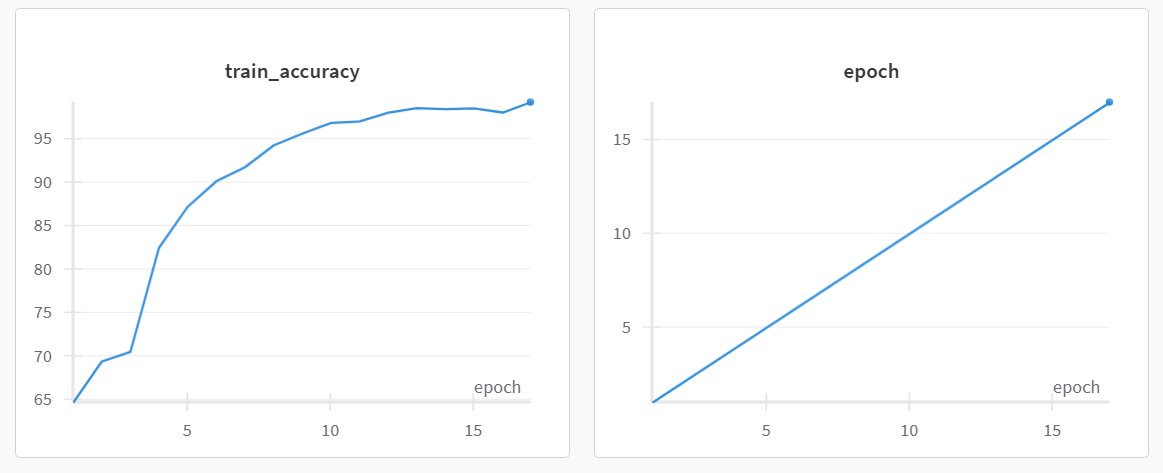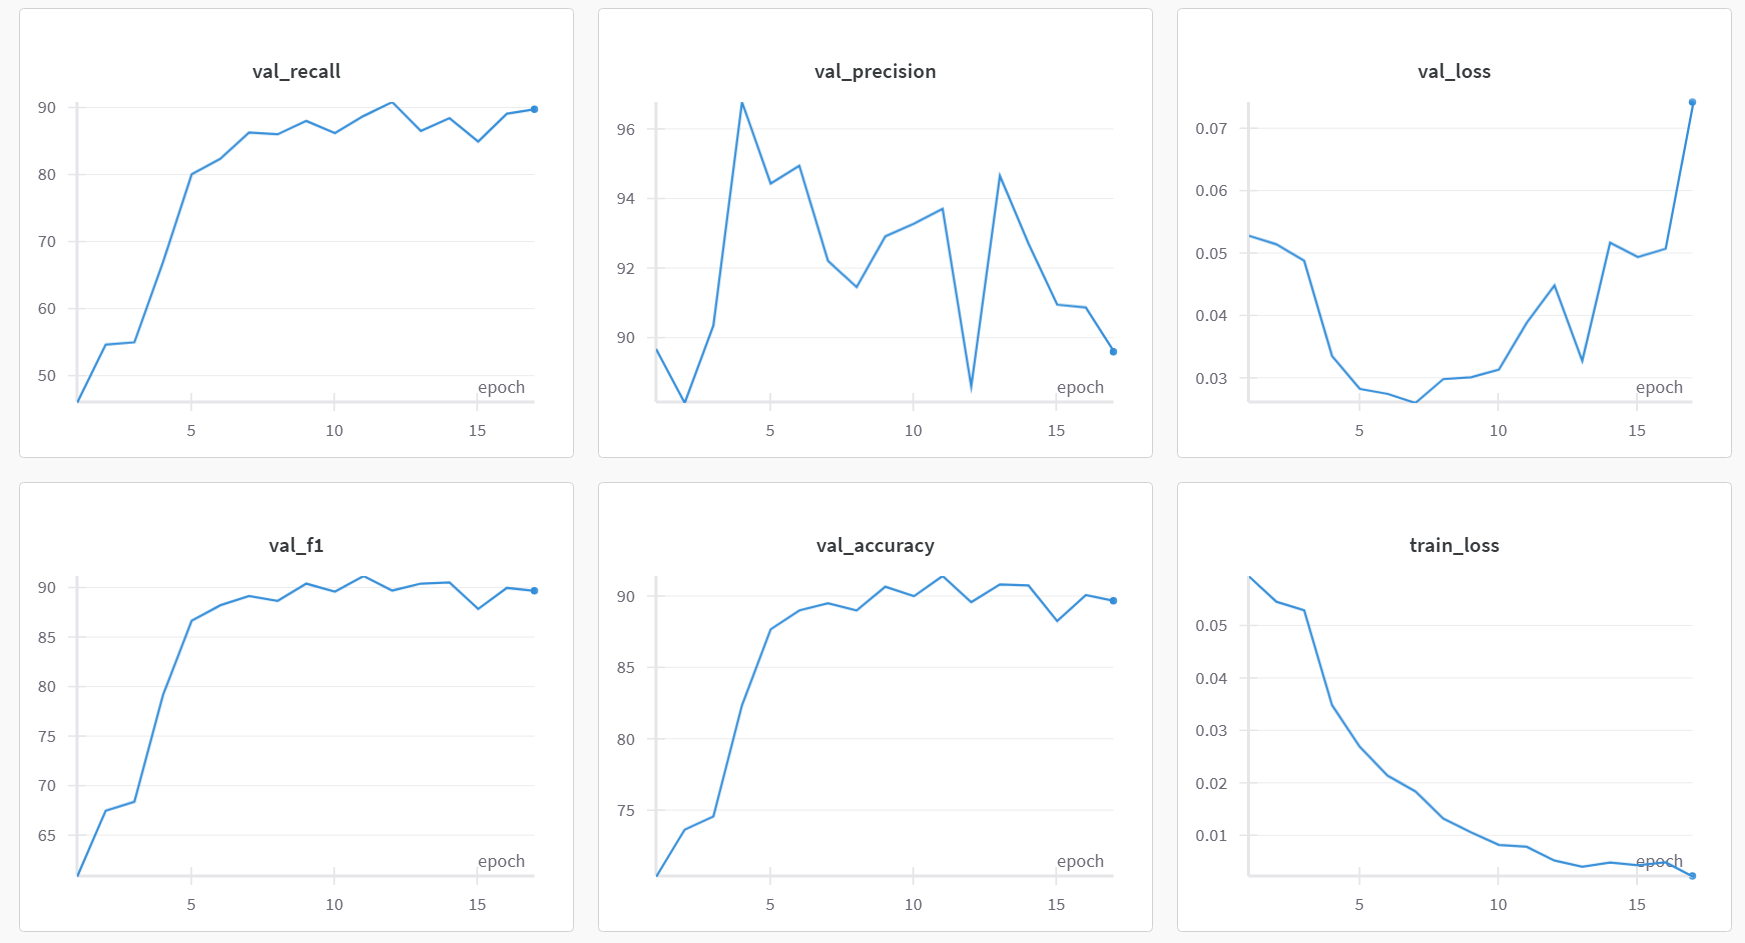

In [28]:
results = []
alphas = [0.25, 0.5, 0.75, 0.9]
gammas = [0.5, 1.0, 2.0, 5.0]
n_epochs = 2

for alpha in alphas:
    for gamma in gammas:
        print(f'Тест: alpha={alpha}, gamma={gamma}')
        print()
        model = DeepLabWithClassifier(seg_model_path, num_classes_clf=2).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)

        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            for images, masks, labels in train_dataloader:
                images, masks, labels = images.to(device), masks.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images, seg_mask=masks)
                loss = focal_loss_new(outputs, labels, alpha, gamma)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
            train_loss = running_loss / len(train_dataloader.dataset)
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}")

        _, _, recall, _, _ = evaluate(model, val_dataloader, threshold=0.5)
        print(f'Val Recall: {recall:.2f}%')
        results.append({'alpha': alpha, 'gamma': gamma, 'recall': recall})

results_sorted = sorted(results, key=lambda x: x['recall'], reverse=True)

Тест: alpha=0.25, gamma=0.5



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2, Loss: 0.1660
Epoch 2/2, Loss: 0.1511
Val Recall: 46.82%
Тест: alpha=0.25, gamma=1.0

Epoch 1/2, Loss: 0.1170
Epoch 2/2, Loss: 0.1075
Val Recall: 42.85%
Тест: alpha=0.25, gamma=2.0

Epoch 1/2, Loss: 0.0596
Epoch 2/2, Loss: 0.0550
Val Recall: 48.22%
Тест: alpha=0.25, gamma=5.0

Epoch 1/2, Loss: 0.0076
Epoch 2/2, Loss: 0.0071
Val Recall: 47.48%
Тест: alpha=0.5, gamma=0.5

Epoch 1/2, Loss: 0.1991
Epoch 2/2, Loss: 0.1835
Val Recall: 70.97%
Тест: alpha=0.5, gamma=1.0

Epoch 1/2, Loss: 0.1405
Epoch 2/2, Loss: 0.1300
Val Recall: 77.01%
Тест: alpha=0.5, gamma=2.0

Epoch 1/2, Loss: 0.0703
Epoch 2/2, Loss: 0.0657
Val Recall: 74.86%
Тест: alpha=0.5, gamma=5.0

Epoch 1/2, Loss: 0.0088
Epoch 2/2, Loss: 0.0083
Val Recall: 79.24%
Тест: alpha=0.75, gamma=0.5

Epoch 1/2, Loss: 0.1716
Epoch 2/2, Loss: 0.1571
Val Recall: 96.36%
Тест: alpha=0.75, gamma=1.0

Epoch 1/2, Loss: 0.1201
Epoch 2/2, Loss: 0.1111
Val Recall: 92.97%
Тест: alpha=0.75, gamma=2.0

Epoch 1/2, Loss: 0.0601
Epoch 2/2, Loss: 0.0

In [29]:
print('\n Лучшие настройки по Recall')
for r in results_sorted[:10]:
    print(f"alpha={r['alpha']}, gamma={r['gamma']} for Recall: {r['recall']:.2f}%")


 Лучшие настройки по Recall
alpha=0.9, gamma=0.5 for Recall: 100.00%
alpha=0.9, gamma=1.0 for Recall: 100.00%
alpha=0.9, gamma=2.0 for Recall: 100.00%
alpha=0.9, gamma=5.0 for Recall: 100.00%
alpha=0.75, gamma=0.5 for Recall: 96.36%


Для начала возьмём alpha=0.75, gamma=0.5, хотя и эти числа кажутся подозрительными

In [30]:
def evaluate_new(model, dataloader, threshold, alpha, gamma):
    model.eval()
    total_loss = 0.0
    total = tp = fn = fp = 0
    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            loss = focal_loss_new(outputs, labels, alpha, gamma)
            total_loss += loss.item() * labels.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:,1] > threshold).long()

            total += labels.size(0)

            tp += ((preds == 1) & (labels == 1)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()

    avg_loss = total_loss / total
    recall = 100 * tp / (tp + fn + 1e-8)
    precision = 100 * tp / (tp + fp + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = 100 * (tp + (total - tp - fn - fp)) / total
    return avg_loss, accuracy, recall, precision, f1

In [31]:
def train_model_new(num_epochs, model, optimizer, threshold, alpha, gamma):
    early_stopping = EarlyStopping(patience=5, delta=0.1, verbose=True, save_path='best_{metric}.pth')
    unfreeze_epoch = 3

    for epoch in range(num_epochs):
        if epoch == unfreeze_epoch:
            print('Разморозка backbone')
            unfreeze_backbone(model)
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=optimizer.defaults['lr'])
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (images, masks, labels) in enumerate(train_dataloader):
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, masks)
            loss = focal_loss_new(outputs, labels, alpha, gamma)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:,1] > 0.5).long()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}')
        train_loss = running_loss / total
        train_accuracy = 100 * correct / total

        val_loss, val_acc, val_rec, val_prec, val_f1 = evaluate_new(model, val_dataloader, threshold=threshold, alpha=alpha, gamma=gamma)

        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_recall': val_rec,
            'val_precision': val_prec,
            'val_f1': val_f1})

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Recall: {val_rec:.2f}%,  Val F1: {val_f1:.2f}')

        '''if early_stopping(model, val_f1):
            print('Early stopping triggered...')
            break'''
        if early_stopping(model, val_loss=val_loss, val_accuracy=val_acc, val_f1=val_f1, val_recall=val_rec):
            print('Early stopping triggered...')
            break

In [32]:
wandb.init(project="skin_lesion_classification", config={
    "learning_rate": 0.0001,
    "epochs": 100,
    "batch_size": 32,
    "architecture": "deeplab_cls_best_alpha_gamma",
    "dataset": "HAM10000+ISIC"})

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_accuracy,▁▂▂▅▆▆▆▇▇████████
train_loss,█▇▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▂▅▇▇▇▇███▇██▇█▇
val_f1,▁▃▃▅▇▇█▇██████▇██
val_loss,▅▅▄▂▁▁▁▂▂▂▃▄▂▅▄▅█
val_precision,▂▁▃█▆▇▄▄▅▅▆▁▆▅▃▃▂
val_recall,▁▂▂▄▆▇▇▇█▇██▇█▇██
epoch,17
train_accuracy,99.21875
train_loss,0.00223


In [33]:
model = DeepLabWithClassifier(seg_model_path, num_classes_clf=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)
train_model_new(num_epochs=config.epochs, model=model, optimizer=optimizer, threshold=0.5, alpha=0.75, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 0/352
Epoch 1, Batch 10/352
Epoch 1, Batch 20/352
Epoch 1, Batch 30/352
Epoch 1, Batch 40/352
Epoch 1, Batch 50/352
Epoch 1, Batch 60/352
Epoch 1, Batch 70/352
Epoch 1, Batch 80/352
Epoch 1, Batch 90/352
Epoch 1, Batch 100/352
Epoch 1, Batch 110/352
Epoch 1, Batch 120/352
Epoch 1, Batch 130/352
Epoch 1, Batch 140/352
Epoch 1, Batch 150/352
Epoch 1, Batch 160/352
Epoch 1, Batch 170/352
Epoch 1, Batch 180/352
Epoch 1, Batch 190/352
Epoch 1, Batch 200/352
Epoch 1, Batch 210/352
Epoch 1, Batch 220/352
Epoch 1, Batch 230/352
Epoch 1, Batch 240/352
Epoch 1, Batch 250/352
Epoch 1, Batch 260/352
Epoch 1, Batch 270/352
Epoch 1, Batch 280/352
Epoch 1, Batch 290/352
Epoch 1, Batch 300/352
Epoch 1, Batch 310/352
Epoch 1, Batch 320/352
Epoch 1, Batch 330/352
Epoch 1, Batch 340/352
Epoch 1, Batch 350/352
Epoch 1/100, Train Loss: 0.1711, Train Acc: 53.75%, Val Loss: 0.1546, Val Acc: 69.69%, Val Recall: 89.25%,  Val F1: 74.65
Сохранены новые лучшие веса для loss модели в: best_loss.pth


Получился ужас, всё взорвалось, надо дальше подбирать параметры, а пока протестирую веса от первого запуска

Epoch 12/100, Train Loss: 0.0053, Train Acc: 97.98%, Val Loss: 0.0449, Val Acc: 89.58%, Val Recall: 90.82%,  Val F1: 89.71

In [20]:
model.load_state_dict(torch.load('/content/best_recall.pth'))
model.to(device)

DeepLabWithClassifier(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [35]:
best_metrics = []
for thr in [0.3, 0.4, 0.5, 0.6, 0.7]:
    val_loss, acc, rec, prec, f1 = evaluate(model, val_dataloader, threshold=thr)
    print(f'Threshold={thr:.2f} — Acc: {acc:.2f}%, Recall: {rec:.2f}%, Precision: {prec:.2f}%, F1: {f1:.2f}')
    best_metrics.append((thr, acc, rec, prec, f1))

Threshold=0.30 — Acc: 87.63%, Recall: 95.20%, Precision: 82.69%, F1: 88.50
Threshold=0.40 — Acc: 89.33%, Recall: 93.55%, Precision: 86.27%, F1: 89.76
Threshold=0.50 — Acc: 89.58%, Recall: 90.82%, Precision: 88.62%, F1: 89.71
Threshold=0.60 — Acc: 89.83%, Recall: 87.92%, Precision: 91.40%, F1: 89.63
Threshold=0.70 — Acc: 89.45%, Recall: 83.54%, Precision: 94.75%, F1: 88.79


In [36]:
def evaluate_model():
    test_loss, test_accuracy, test_recall, test_prec, test_f1 = evaluate(model, test_dataloader, threshold=0.3)
    print(f'Test Loss: {test_loss:.4f}, '
          f'Acc: {test_accuracy:.2f}%, '
          f'Recall: {test_recall:.2f}%, '
          f'Precision: {test_prec:.2f}%, '
          f'F1: {test_f1:.2f}%')

evaluate_model()

Test Loss: 0.0440, Acc: 88.71%, Recall: 95.53%, Precision: 84.06%, F1: 89.43%


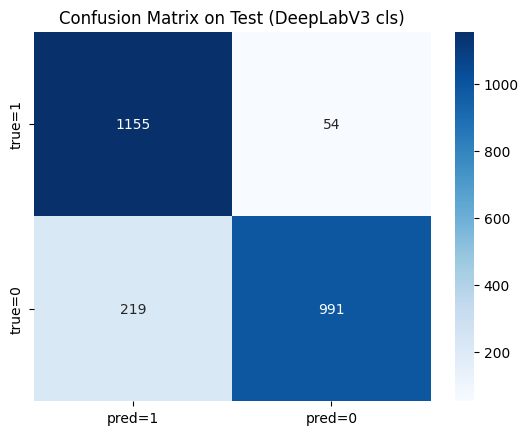

In [21]:
all_probs, all_labels = [], []
model.eval()
with torch.no_grad():
    for imgs, msks, lbls in test_dataloader:
        imgs, msks = imgs.to(device), msks.to(device)
        out = model(imgs, seg_mask=msks)
        probs = torch.softmax(out,1)[:,1].cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(lbls.numpy())

# preds = (np.array(all_probs) > best_threshold).astype(int)
preds = (np.array(all_probs) > 0.3).astype(int)
cm = confusion_matrix(all_labels, preds, labels=[1,0])  # [ [TP, FN], [FP, TN] ]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pred=1','pred=0'], yticklabels=['true=1','true=0'])
plt.title('Confusion Matrix on Test (DeepLabV3 cls)')
plt.show()

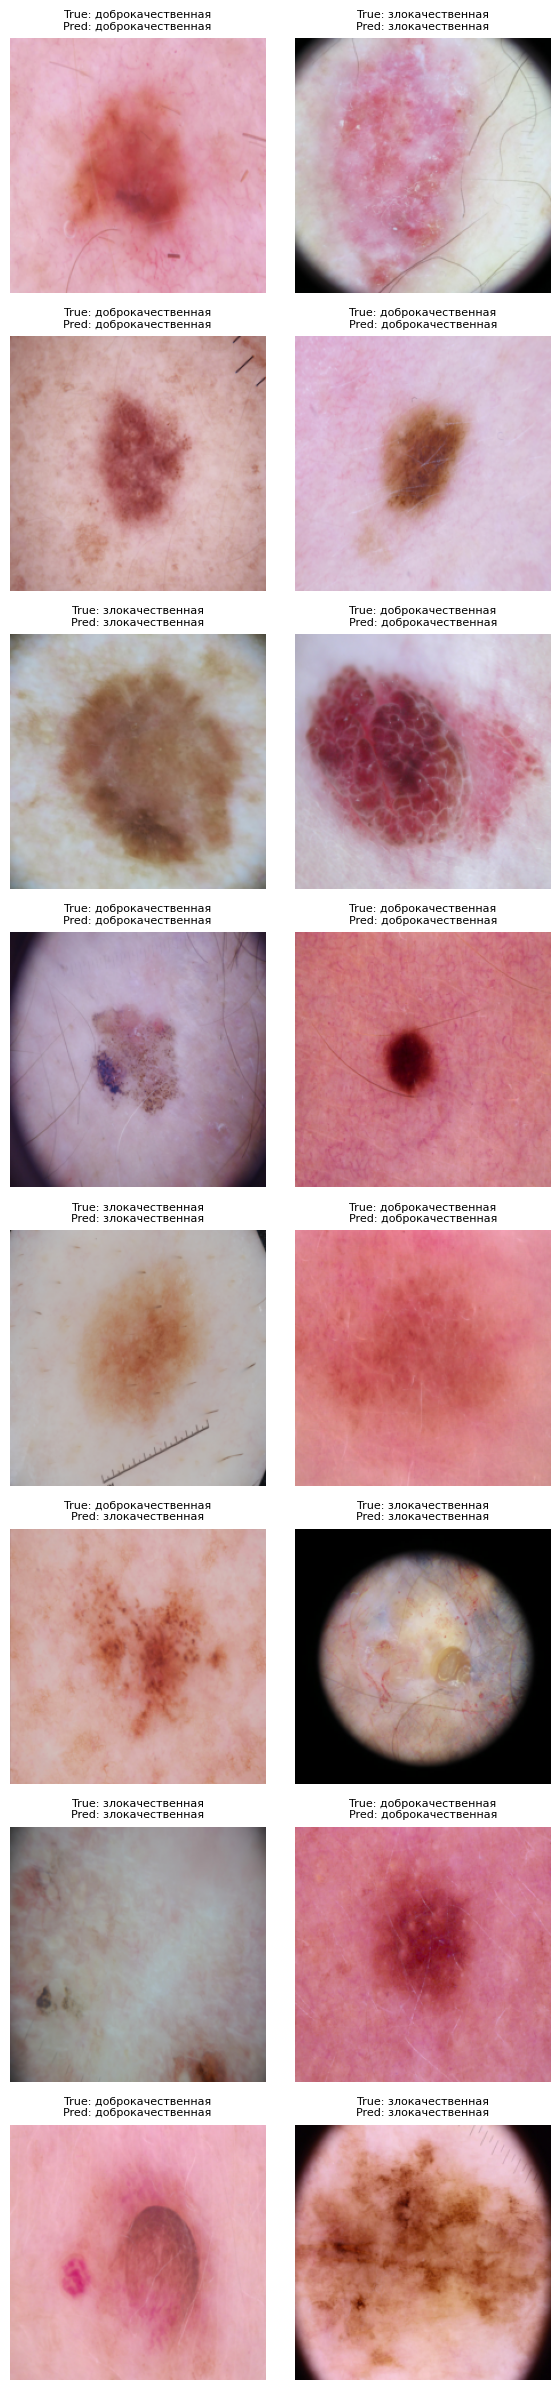

In [22]:
def visualize_predictions(model, dataloader, grid_shape=(8, 2)):
    model.eval()
    n_rows, n_cols = grid_shape
    total_images = n_rows * n_cols
    label_map = {0: 'доброкачественная', 1: 'злокачественная'}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    # Преобразуем axes в одномерный массив для удобного перебора
    if isinstance(axes, (list, np.ndarray)):
        axes = axes.flatten()
    else:
        axes = [axes]

    images_shown = 0

    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            _, preds = torch.max(outputs, 1)
            images = images.cpu()
            for i in range(images.shape[0]):
                if images_shown >= total_images:
                    break
                img = images[i].permute(1, 2, 0)
                img = img * 0.5 + 0.5
                ax = axes[images_shown]
                ax.imshow(img.numpy())
                true_label = label_map[labels[i].item()]
                pred_label = label_map[preds[i].item()]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
                ax.axis('off')
                images_shown += 1
            if images_shown >= total_images:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataloader, grid_shape=(8, 2))

In [ ]:
#T4